
# Обучение без учителя. Кластеризация

Интуитивная постановка задачи кластеризации довольно проста и представляет из себя наше желание сказать: "Вот тут у меня насыпаны точки. Я вижу, что они сваливаются в какие-то кучки вместе. Было бы круто иметь возможность эти точки относить к кучкам и в случае появления новой точки на плоскости говорить, в какую кучку она падает." Из такой постановки видно, что пространства для фантазии получается много, и от этого возникает соответствующее множество алгоритмов решения этой задачи. Перечисленные алгоритмы ни в коем случае не описывают данное множество полностью, но являются примерами самых популярных методов решения задачи кластеризации.

Картинка взята с сайта https://scikit-learn.org/stable/modules/clustering.html
![Clustering_methods](img/clustering.png)

---


### K-means

Алгоритм К-means один из самых популярных алгоритмов кластеризации и очень легко представляется в виде простого псевдокода:

1. Выбрать количество кластеров, которое кажется оптимальным для данных.
2. Сгенерировать случайным образом в пространство наших данных  точек (центроидов).
3. Для каждой точки набора данных посчитать, к какому центроиду она ближе.
4. Переместить каждый центроид в центр выборки, которую отнесли к этому центроиду.
5. Повторять последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся" (обычно это значит, что их смещение относительно предыдущего положения не превышает какого-то заранее заданного небольшого значения).

В случае обычной евклидовой метрики для точек лежащих на плоскости, этот алгоритм очень просто расписывается аналитически и рисуется.

In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.decomposition import PCA

# функция, которая считает расстояния между парами точек из двух массивов
from scipy.spatial.distance import cdist

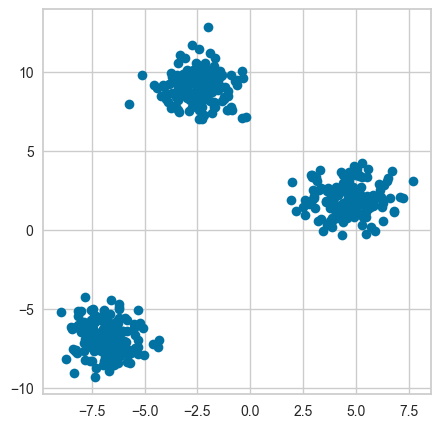

In [28]:
# Сгенерируем и визуализируем точки

X, y = make_blobs(n_samples=500, centers=3, n_features=2,  random_state=42)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [29]:
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

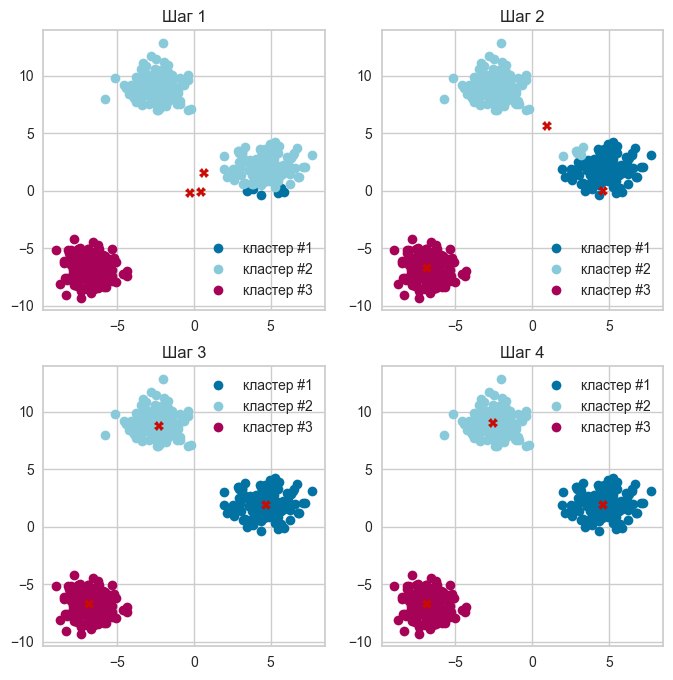

In [30]:
# А теперь нарисуем всю эту красоту
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='кластер #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='кластер #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='кластер #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Шаг {:}'.format(i + 1));

Также стоит заметить, что хоть мы и рассматривали **евклидово расстояние**, алгоритм будет сходиться и в случае любой другой метрики, поэтому для различных задач кластеризации в зависимости от данных можно экспериментировать не только с количеством шагов или критерием сходимости, но и с метрикой, по которой мы считаем расстояния между точками и центроидами кластеров.


Другой особенностью этого алгоритма является то, что он чувствителен к исходному положению центроид кластеров в пространстве. В такой ситуации спасает несколько последовательных запусков алгоритма с последующим усреднением полученных кластеров.

В отличие от задачи классификации или регресии, в случае кластеризации сложнее выбрать критерий, с помощью которого было бы просто представить задачу кластеризации как задачу оптимизации.
В случае `k-Means` распространен вот такой критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$ J(C) = \sum_{k=1}^{K} \sum_{i \leq C_{k}} ||x_{i}-\mu_{k}||^2 \ \to \ \min_{k} $$

здесь $ C $ – множество кластеров мощности $ K $, $ \mu_{k} $ – центроид кластера $ C_{k} $.


Понятно, что здравый смысл в этом есть: мы хотим, чтобы точки располагались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).
Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". **Или более формально:**

$$ D(k) = \frac{|J(C_{k}-J(C_{k+1}|}{|J(C_{k}|} \to \min_{k} $$

## Что-что?

/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

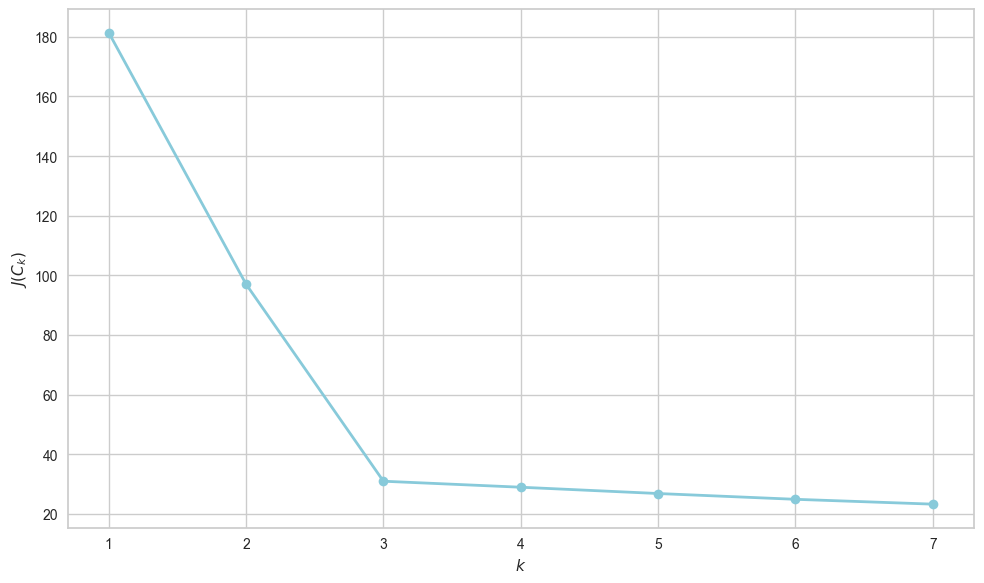

In [31]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10,6), tight_layout=True)
plt.grid(True)
plt.plot(range(1, 8), inertia, 'o-c', linewidth=2);
plt.xlabel('$k$')
plt.ylabel('$J(C_{k})$');

In [32]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/ilya/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

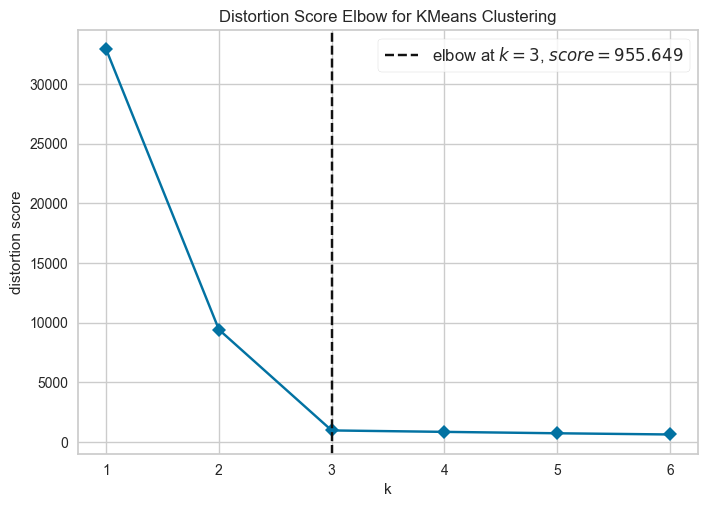

In [33]:
# Также для выделения оптимального набора параметров, можно воспользоватся библиотекой KElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(1,7), metric = 'distortion', timings = False);
visualizer.fit(X);
visualizer.show();

Видим, что  падает сильно при увеличении числа кластеров с $ 1 $ до $ 2 $ и с $ 2 $ до $ 3 $ и уже не так сильно – при изменении  с $ 3 $ до $ 4 $. Значит, в данной задаче оптимально задать **3** кластера.

---

### Все ли так просто?

Само по себе решение задачи `K-means` `NP-трудное (NP-hard)`, и для размерности $ d $, числа кластеров $ k $ и числа точек $ n $ решается за $ O(n^{dk+1}) $. Для решения такой боли часто используются эвристики, например `MiniBatch K-means`, который для обучения использует не весь датасет целиком, а лишь маленькие его порции (batch) и обновляет центроиды используя среднее за всю историю обновлений центроида от всех относящихся к нему точек. Сравнение обычного `K-means` и его `MiniBatch` имплементации можно посмотреть в документации `scikit-learn`.


Реализация алгоритма в `scikit-learn` обладает массой удобных плюшек, таких как возможность задать количество запусков через параметр `n_init`, что даст более устойчивые центроиды для кластеров в случае скошенных данных. К тому же эти запуски можно делать параллельно, не жертвуя временем вычисления.


> # Задание
>
> Для нового набора данных `X_mnist_tsne`, полученного при помощи снижения размерности, определите наиболее оптимальное количество кластеров при работе алгоритма `K-Means`. Про алгоритмы снижения размерности мы поговорим в следующем занятии, сейчас просто рассматриваем как признаковое пространство, для которого необходимо реализовать кластеризацию.

/tmp/ipykernel_8444/320004853.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


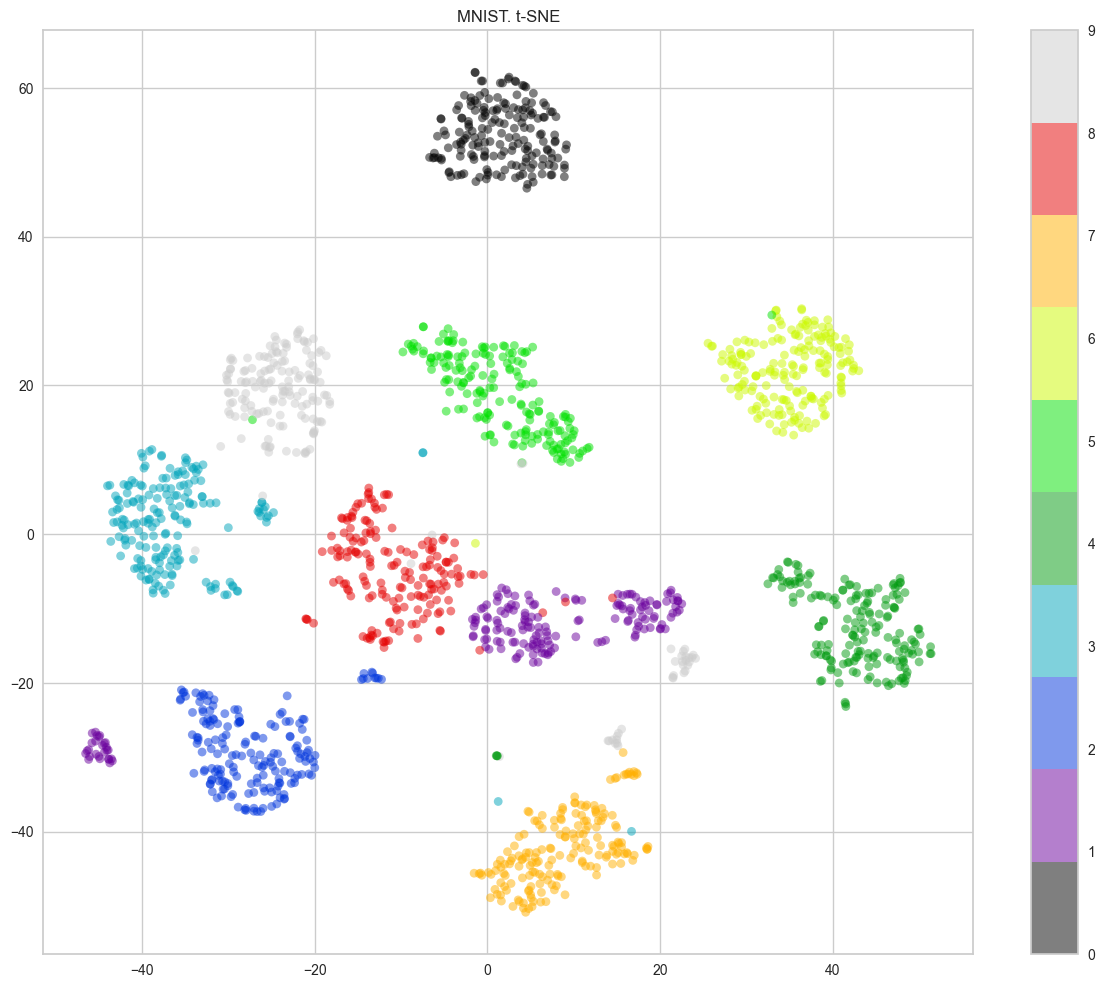

In [34]:
# загрузим данные по цифрам
digits = datasets.load_digits()
X_mnist = digits.data
y_mnist = digits.target

# Создадим объект TSNE
tSNE_mnist = TSNE(random_state=17)

# настройка модели
X_mnist_tsne = tSNE_mnist.fit_transform(X_mnist)

# визуализация данных
plt.figure(figsize=(15,12))
plt.scatter(X_mnist_tsne[:, 0], X_mnist_tsne[:, 1], c=y_mnist, 
            edgecolor='none', alpha=0.5, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE');

In [35]:
# Оптимальное количество кластеров для MNIST
# type your code here


## Affinity Propogation

Этот алгоритм был опубликован в 2007-м году Бренданом Фреем и Дельбертом Дьюком в Science.

Ещё один пример алгоритма кластеризации. В отличие от алгоритма `К-means`, данный подход не требует заранее определять число кластеров, на которое мы хотим разбить наши данные. Основная идея алгоритма заключается в том, что нам хотелось бы, чтобы наши наблюдения кластеризовались в группы на основе того, как они "общаются", или насколько они похожи друг на друга.


Заведём для этого какую-нибудь метрику "похожести", определяющуюся тем, что $ s(x_{i},x_{j}) > s(x_{i},x_{k}) $ если наблюдение $ x_{i} $ больше похоже на наблюдение $ x_{j} $, чем на $ x_{k} $. Простым примером такой похожести будет отрицательный квадрат расстояния $ s(x_{i},x_{j}) = -||x_{i}-x_{j}||^2 $.


Теперь опишем сам процесс "общения". Для этого заведём две матрицы, инициализируемые нулями, одна из которых $ r_{i,k} $ будет описывать, насколько хорошо $ k $-тое наблюдение подходит для того, чтобы быть "примером для подражания" для $ i $-того наблюдения относительно всех остальных потенциальных "примеров", а вторая — $ a_{i,k} $ будет описывать, насколько правильным было бы для $ i $-того наблюдения выбрать $ k $-тое в качестве такого "примера". 

После этого данные матрицы обновляются по очереди по правилам:

$$ r_{i,k} \leftarrow s(x_{i},x_{k} - \max_{k'\neq k} \{ a_{i,k'}+s(x_{i},x_{k}' \} $$
$$ a_{i,k} \leftarrow min (0,r_{k,k}+\sum_{i' \notin \{ i,k \} } max(0, r_{i',k})),\ i \neq k $$
$$ a_{k,k} \leftarrow \sum_{i'\neq k} \max(o,r_{i',k}) $$

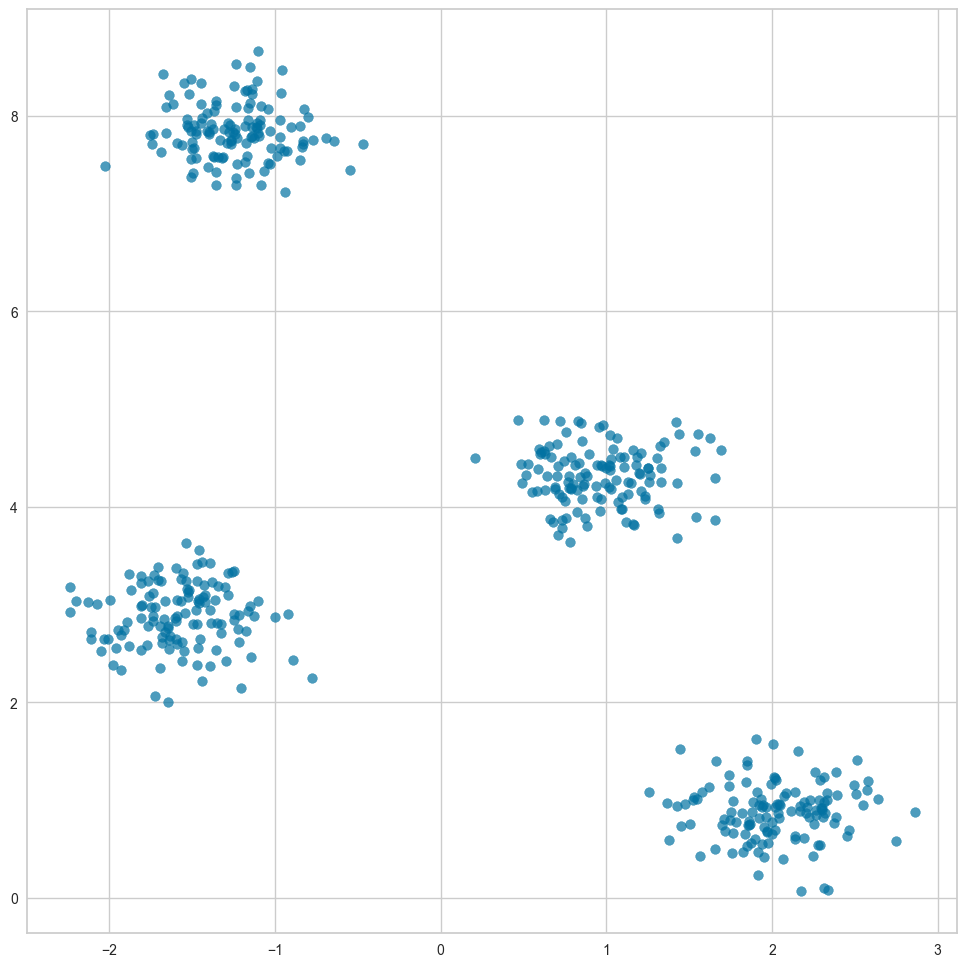

In [36]:
# Сгенерируем ещё набор точек и визуализируем
X, clusters = make_blobs(n_samples=500, centers=4, cluster_std=.3, random_state=0)
plt.figure(figsize=(12,12));
plt.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b');

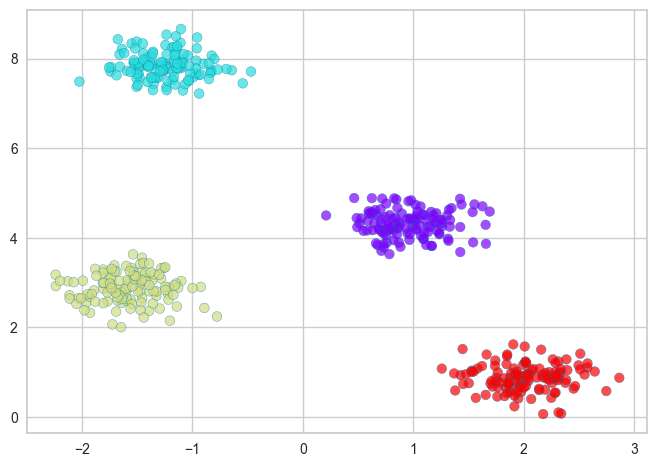

In [37]:
# Инициализация и обучение модели
af = AffinityPropagation()
clustering = af.fit(X)

plt.scatter(X[:,0], X[:,1], c=clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b');

> # Задание
>
> Реализовать кластеризацию для цветов Ириса на всем признаковом пространстве. Отобразить график в осях pca_2d, которые получены при помощи снижения размерности. Про этот алгоритм мы также поговорим в следующем занятии, пока просто рассматриваем это как помощь для визуализации.

In [38]:
# Загрузка данных и кластериазция. Метки кластеров находятся в свойсте labels_ объекта AffinityPropagation
iris = datasets.load_iris()
# type your code here

In [39]:
# Дальше код для отрисовки
pca = PCA(n_components=2).fit(iris.data)
pca_2d = pca.transform(iris.data)

plt.scatter(pca_2d[:, 0], pca_2d[:,1], c=, # type labels here
            cmap='rainbow', marker='*')
        
plt.show()

SyntaxError: invalid syntax (1733215589.py, line 5)

># Задание
>
>Реализовать кластеризацию для MNIST.

## DBscan

`DBSCAN (Density-based spatial clustering of applications with noise, плотностной алгоритм пространственной кластеризации с присутствием шума)`, как следует из названия, оперирует плотностью данных. На вход он просит уже знакомую матрицу близости и два загадочных параметра — радиус -окрестности и количество соседей. Так сразу и не поймёшь, как их выбрать, причём здесь плотность, и почему именно `DBSCAN` хорошо расправляется с шумными данными. Без этого сложно определить границы его применимости.

### Формальное описание

Введём несколько определений. Пусть задана некоторая симметричная функция расстояния $ \rho(x,y) $ и константы $\epsilon$ и $m$. Тогда

1. Назовём область $E(x)$, для которой $\forall y:\rho (x,y) \leq \epsilon $, $\epsilon$-окрестностью объекта $x$.
2. Корневым объектом или ядерным объектом степени $m$ называется объект, $\epsilon$-окрестность которого содержит не менее $m$ объектов: $|E(x)| \geq m$.
3. Объект $p$ непосредственно плотно-достижим из объекта $q$, если $p \in E(q)$ и $q$ — корневой объект.
4. Объект $p$ плотно-достижим из объекта $q$, если $\exists p_1, p_2, ..., p_n, p_1=q,p_n=p$, такие что $\forall i \in 1...n-1:p_{i+1}$ непосредственно плотно-достижим из $p_{i}$

Выберем какой-нибудь корневой объект $p$ из датасета, пометим его и поместим всех его непосредственно плотно-достижимых соседей в список обхода. Теперь для каждой $q$ из списка: пометим эту точку, и, если она тоже корневая, добавим всех её соседей в список обхода. Тривиально доказывается, что кластеры помеченных точек, сформированные в ходе этого алгоритма максимальны (т.е. их нельзя расширить ещё одной точкой, чтобы удовлетворялись условия) и связны в смысле плотно-достижимости. Отсюда следует, что если мы обошли не все точки, можно перезапустить обход из какого-нибудь другого корневого объекта, и новый кластер не поглотит предыдущий.

По факту, это замаскированный обход графа в ширину с ограничениями *с условиями обхода и краевыми точками.*

Существуют эвристики для выбора $m$ и $\epsilon$. Чаще всего применяется такой метод и его вариации:

1. Выберите $m$. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять $m$.
2. Вычислите среднее расстояние по $m$ ближайшим соседям для каждой точки. Т.е. если $m=3$, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.
3. Сортируем полученные значения по возрастанию и выводим на экран.
4. Видим что-то вроде такого резко возрастающего графика. Следует взять $\epsilon$ где-нибудь в полосе, где происходит самый сильный перегиб. Чем больше $\epsilon$, тем больше получатся кластеры, и тем меньше их будет.

![Как выбрать параметры DBSCAN](img\dbscan.png)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# Настройка гиперпараметров
num_samples_total = 1000
cluster_centers = [(-1,0), (7,7), [-2,8]]
num_classes = len(cluster_centers)
epsilon = 1.0
min_samples = 13

# Генерация данных
X, y = make_blobs(n_samples = num_samples_total, centers = cluster_centers, n_features = num_classes, center_box=(0, 1), cluster_std = 0.9)

# Вычисление DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(X)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

# Отрисовка графика
plt.scatter(X[:,0], X[:,1], marker="o", c=db.labels_, cmap='rainbow', picker=True)
plt.title(str(num_classes) + ' clusters with data')
plt.xlabel('Axis X[0]')
plt.ylabel('Axis X[1]')
plt.show()

># Задание
>
>Необходимо на основании предыдущих результатов удалить шум из данных и нарисовать новые кластеры

In [ ]:
# Удаление шума

# Отрисовка данных


># Задание
>
> Реализовать кластеризацию для Ирисов. Сколько кластеров находит DBSCAN? Какое количество точек отнесены к шуму?

In [ ]:
# type your code here

In [ ]:
# Уменьшаем размерность при помощи метода главных компонент
pca = PCA(n_components=2).fit(iris.data)
pca_2d = pca.transform(iris.data)

# визуализация результатов

## Спектральная кластеризация

Спектральная кластеризация объединяет несколько описанных выше подходов, чтобы получить максимальное количество профита от сложных многообразий размерности меньшей исходного пространства.


Для работы этого алгоритма нам потребуется определить **матрицу похожести наблюдений (adjacency matrix)**. Можно это сделать таким же образом, как и для **Affinity Propagation** выше: $ A_{i,j}=-||x_{i}-x_{j}||^2 $. Эта матрица также описывает полный граф с вершинами в наших наблюдениях и рёбрами между каждой парой наблюдений с весом, соответствующим степени похожести этих вершин. Для нашей выше выбранной метрики и точек, лежащих на плоскости, эта штука будет интуитивной и простой — две точки более похожи, если ребро между ними короче. Теперь нам бы хотелось разделить наш получившийся граф на две части так, чтобы получившиеся точки в двух графах были в общем больше похожи на другие точки внутри получившейся "своей" половины графа, чем на точки в "другой" половине.

Спектральная кластеризация - это популярный неконтролируемый алгоритм машинного обучения, который часто превосходит другие подходы. Кроме того, спектральная кластеризация очень проста в реализации и может быть эффективно решена стандартными методами линейной алгебры. В спектральной кластеризации сродство, а не абсолютное местоположение (то есть k-означает), определяет, какие точки попадают под какой кластер. Последнее особенно полезно при решении проблем, когда данные образуют сложные формы.

### Алгоритм
**Алгоритм** можно разбить на 4 основных этапа.

1. Построить граф сходства
2. Определить матрицу смежности W, матрицу степени D и матрицу Лапласа L
3. Вычислить собственные векторы матрицы L
4. Используя второй наименьший собственный вектор в качестве входных данных, обучите модель k-средних и используйте ее для классификации данных.

In [ ]:
plt.figure(figsize=(8,8));
X, clusters = make_circles(n_samples=1000, noise=.05, factor=.5, random_state=0)
plt.scatter(X[:,0], X[:,1]);

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering

km = KMeans(init='k-means++', n_clusters=7)
km_clustering = km.fit(X)
plt.scatter(X[:,0], X[:,1], c=km_clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')
plt.scatter(km_clustering.cluster_centers_[:,0], km_clustering.cluster_centers_[:,1], c=range(7), cmap='rainbow', alpha=0.7, edgecolors='b', marker='*')

In [ ]:
km_clustering.cluster_centers_

In [ ]:
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(X)
plt.scatter(X[:,0], X[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

## Агломеративная кластеризация

Наверное самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров — агломеративная кластеризация. Интуиция у алгоритма очень простая:

1. Начинаем с того, что высыпаем на каждую точку свой кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

![Дендограмма](img\dendrogram.png)

Сам процесс поиска ближайших кластеров может происходить с использованием разных методов объединения точек:

1. **Single kinkage** - минимум попарных расстояний между точками из двух кластеров

$$ d(C_{i}, C_{J}) = min_{x_{i} \in C_{i}, x_{j} in C_{j} ||x_{i} - x_{j} ||} $$

2. **Complete linkage** — максимум попарных расстояний между точками из двух кластеров

$$ d(C_{i}, C_{J}) = max_{x_{i} \in C_{i}, x_{j} in C_{j} ||x_{i} - x_{j} ||} $$

3. **Average linkage** — среднее попарных расстояний между точками из двух кластеров

$$ d(C_{i}, C_{J}) = {\frac{1}{n_{i}n_{j}} \sum_{x_{i} \in C_{i}} \sum_{x_{j} \in C_{j} ||x_{i} - x_{j}||}} $$

4. **Centroid linkage** — расстояние между центроидами двух кластеров

$$ d(C_{i}, C_{J}) = ||\mu_{i}-\mu_{j}|| $$

Профит первых трёх подходов по сравнению с четвёртым в том, что для них не нужно будет пересчитывать расстояния каждый раз после склеивания, что сильно снижает вычислительную сложность алгоритма.


По итогам выполнения такого алгоритма можно также построить замечательное дерево склеивания кластеров и глядя на него определить, на каком этапе нам было бы оптимальнее всего остановить алгоритм. Либо воспользоваться тем же правилом локтя, что и в `k-means`.


К счастью для нас в питоне уже есть замечательные инструменты для построения таких дендрограмм для агломеративной кластеризации. Рассмотрим на примере наших кластеров из `k-means`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from sklearn.datasets import make_blobs


X = np.zeros((150, 2))

np.random.seed(seed=42)
cluster_centers = [[1,0], [-3,-1], [4,5]]
X, y = make_blobs(n_samples = 30, centers = cluster_centers, n_features = 1, cluster_std = 0.5)

distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=2)

In [ ]:
print(Z)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=y, cmap='rainbow', alpha=0.7, edgecolors='b')
ax = plt.gca()

for i in range(30):
    ax.annotate(i, (X[i,0] + 0.2, X[i,1]))

# Метрики качества кластеризации

Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Во-первых, такие оценки не должны зависеть от самих значений меток, а только от самого разбиения выборки. Во-вторых, не всегда известны истинные метки объектов, поэтому также нужны оценки, позволяющие оценить качество кластеризации, используя только неразмеченную выборку.


Выделяют внешние и внутренние метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.


Все указанные ниже метрики реализованы в `sklearn.metrics`.

## Adjusted Rand Index (ARI)


Предполагается, что известны истинные метки объектов. Данная мера не зависит от самих значений меток, а только от разбиения выборки на кластеры. Пусть $ n $ — число объектов в выборке. Обозначим через $ a $ — число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, через $ b $ — число пар объектов, имеющих различные метки и находящихся в разных кластерах. Тогда *Rand Index* это

$$ RI = \frac{2(a+b)}{n(n-1)} $$

То есть это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Rand Index (RI) выражает схожесть двух разных кластеризаций одной и той же выборки. Чтобы этот индекс давал значения близкие к нулю для случайных кластеризаций при любом $ n $ и числе кластеров, необходимо нормировать его. Так определяется *Adjusted Rand Index*:

$$ ARI = \frac{RI-E[RI]}{\max(RI)-E[RI]} $$

Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки. **ARI** принимает значения в диапазоне $ [-1,1] $. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, — случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при **ARI=1**).

## Adjusted Mutual Information (AMI)


Данная мера очень похожа на **ARI**. Она также симметрична, не зависит от значений и перестановок меток. Определяется с использованием функции энтропии, интерпретируя разбиения выборки, как дискретные распределения (вероятность отнесения к кластеру равна доле объектов в нём). Индекс **MI** определяется как взаимная информация для двух распределений, соответствующих разбиениям выборки на кластеры. Интуитивно, взаимная информация измеряет долю информации, общей для обоих разбиений: насколько информация об одном из них уменьшает неопределенность относительно другого.


Аналогично **ARI** определяется индекс **AMI**, позволяющий избавиться от роста индекса **MI** с увеличением числа классов. Он принимает значения в диапазоне $ [0,1] $. Значения, близкие к нулю, говорят о независимости разбиений, а близкие к единице – об их схожести (совпадении при **AMI=1**).

## Гомогенность, полнота, V-мера


Формально данные меры также определяются с использованием функций энтропии и условной энтропии, рассматривая разбиения выборки как дискретные распределения:

$$ h=1-\frac{H(C|K)}{H(C)},c=1-\frac{H(K|C)}{H(K)} $$

здесь $ K $ — результат кластеризации, $ C $ — истинное разбиение выборки на классы. Таким образом,  измеряет, насколько каждый кластер состоит из объектов одного класса, а  — насколько объекты одного класса относятся к одному кластеру. Эти меры не являются симметричными. Обе величины принимают значения в диапазоне $ [0,1] $, и большие значения соответствуют более точной кластеризации. Эти меры не являются нормализованными, как **ARI** или **AMI**, и поэтому зависят от числа кластеров. Случайная кластеризация не будет давать нулевые показатели при большом числе классов и малом числе объектов. В этих случаях предпочтительнее использовать **ARI**. Однако при числе объектов более 1000 и числе кластеров менее 10 данная проблема не так явно выражена и может быть проигнорирована.
Для учёта обеих величин $ h $ и $ c $ одновременно вводится $ V $-мера, как их среднее гармоническое:

$$ v=2\frac{hc}{h+c} $$

Она является симметричной и показывает, насколько две кластеризации схожи между собой.

### Силуэт

В отличие от описанных выше метрик, данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $ a $ — среднее расстояние от данного объекта до объектов из того же кластера, через  — среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина:

$$ s=\frac{b-a}{\max(a,b)} $$

Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $ [-1;1] $. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.
С помощью силуэта можно выбирать оптимальное число кластеров $ k $ (если оно заранее неизвестно) — выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.


И напоследок давайте посмотрим на эти метрики для наших алгоритмов, запущенных на данных рукописных цифр MNIST:

> # Задание
>
> Для набора данных MNIST посчитать все метрики для алгоритмов: K-means, Affinity Propagation, Spectral Clustering, Agglomerative. Какой алгоритм показывает наилучшую метрику Силуэт?

In [ ]:
# Метрики для Digits

# Задание

> Реализовать кластеризацию для набора данных по кредитным картам
>
> 1. Загрузить данные
> 2. Построить распределения параметров
> 3. Кластеризовать данные, используя рассмотренные алгоритмы
> 4. Оценить по метрикам успешность работы алгоритмов

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('data/CreditCard.csv')
df.drop("CUST_ID", axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()